#  Car Pplate Detector 

> PART 4 / DETECT PLATES PRECENCE,COLOR,CORDINATES


<img src="/Users/adrian/Desktop/PY-PROJECTS/Machine_Learning/cart-plate-detector/fonts/img/img3.png" style="width:400px;height 400px"/>


     x [WxH] ---> MODEL ---> Y[presence,xs,ys,xe,ye,plates_color]

     xs -- x start
     xe -- x end

In [2]:
import os
from sys import  getsizeof
from random import randint
import csv

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image,ImageOps, ImageDraw,ImageFont

import numpy as np

import torch, torch.nn as nn, torch.optim as optim

# Preparing DATA SETS

In [4]:
LABEL = '/m/01jfm_'
IMG_SIZE= (120,120)

csv_file  = open('OIDv4_ToolKit/OID/csv_folder/train-annotations-bbox.csv', 'r')
csv_reader= csv.reader(csv_file, delimiter=',')

box_count = 0

data_x    = None
data_y    = None


# 'ImageID', 'Source', 'LabelName', 'Confidence', 'XMin', 'XMax', 'YMin', 'YMax', 'IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction', 'IsInside'
for row in csv_reader:
    ImageID, Source, LabelName, Confidence, XMin, XMax, YMin, YMax, IsOccluded, IsTruncated, IsGroupOf, IsDepiction, IsInside = row
    if LabelName == LABEL:
        if IsGroupOf == '0' and IsOccluded == '0' and IsTruncated == '0':
            if 0.1 < abs(float(XMax) - float(XMin)) < 0.25 and 0.05 < abs(float(YMax) - float(YMin) < 0.2):

                img= Image.open(f'OIDv4_ToolKit/OID/Dataset/train/Vehicle registration plate/{ImageID}.jpg')
                img= ImageOps.grayscale(img)
                img = img.resize(IMG_SIZE)
                
                # plt.figure()
                # plt.imshow(img,cmap='gray')
                # if box_count> 10: 
                #     break


                x_matrix =  np.array(img,dtype=np.float32)
                x_matrix /= 255.0
                
                y_vector = np.array([
                    float(XMax),
                    float(XMin),
                    float(YMax),
                    float(YMin),
                    
                ])


                if box_count == 0:
                    data_x = np.array([x_matrix])
                    data_y = np.array([y_vector])
                else:
                    data_x = np.append(data_x,[x_matrix], axis= 0)
                    data_y = np.append(data_y,[y_vector], axis= 0)

                box_count += 1

print(f"processed {box_count} boxes")
print(f"X shape")
print(f"Y shape {data_y.shape}")




processed 1362 boxes
X shape
Y shape (1362, 4)


# Built the model

In [5]:
modelBOX = nn.Sequential(
    nn.Conv2d( in_channels=1 , out_channels=32, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(3,3)),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(3,3)),
    nn.Flatten(start_dim= 0),

    nn.Linear(in_features=9216, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=4),
    nn.Sigmoid()

)

In [6]:
x = torch. from_numpy(data_x[0]).type(torch.FloatTensor).view(1,*IMG_SIZE)
y = modelBOX(x)
print(y.shape)

torch.Size([4])


# Training

In [52]:
criterionBOX = nn.MSELoss()
optimizerBOX = optim.SGD(modelBOX.parameters(), lr= 0.001)

for epoch in range (1,1000):
    loss = 0 
    for i in range(len(data_x)):
        x= torch.from_numpy(data_x[i]).type(torch.FloatTensor).view(1,*IMG_SIZE)
        y= torch.from_numpy(data_y[i]).type(torch.FloatTensor)
        
        optimizerBOX.zero_grad()
        yp = modelBOX(x)

        loss= criterionBOX(yp, y)

        loss.backward()
        optimizerBOX.step()
    print(f"epoch = {epoch:5} loss= {loss:15.8f}")


epoch =     1 loss=      0.01777194
epoch =     2 loss=      0.01658024
epoch =     3 loss=      0.01638164
epoch =     4 loss=      0.01629005
epoch =     5 loss=      0.01626179
epoch =     6 loss=      0.01623366
epoch =     7 loss=      0.01620364
epoch =     8 loss=      0.01615491
epoch =     9 loss=      0.01612284
epoch =    10 loss=      0.01608479
epoch =    11 loss=      0.01604214
epoch =    12 loss=      0.01598495
epoch =    13 loss=      0.01593757
epoch =    14 loss=      0.01590274
epoch =    15 loss=      0.01584384
epoch =    16 loss=      0.01578801
epoch =    17 loss=      0.01574953
epoch =    18 loss=      0.01570264
epoch =    19 loss=      0.01564907
epoch =    20 loss=      0.01559841
epoch =    21 loss=      0.01554670
epoch =    22 loss=      0.01549009
epoch =    23 loss=      0.01543571
epoch =    24 loss=      0.01539496
epoch =    25 loss=      0.01534176
epoch =    26 loss=      0.01529317
epoch =    27 loss=      0.01525645
epoch =    28 loss=      0.0

# Save the Model

In [54]:
## Save the trained network <--https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(modelBOX.state_dict(),'models/cart-plate-detector-9216-3x3-1362boxes')

# load the saved model

In [43]:
modelBOX.load_state_dict(torch.load('models/cart-plate-detector-9216-3x3-1362boxes'))
modelBOX.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=0, end_dim=-1)
  (7): Linear(in_features=9216, out_features=1024, bias=True)
  (8): ReLU()
  (9): Linear(in_features=1024, out_features=4, bias=True)
  (10): Sigmoid()
)

[0.25133878 0.12813821 0.73770744 0.5951342 ]


<Figure size 640x480 with 0 Axes>

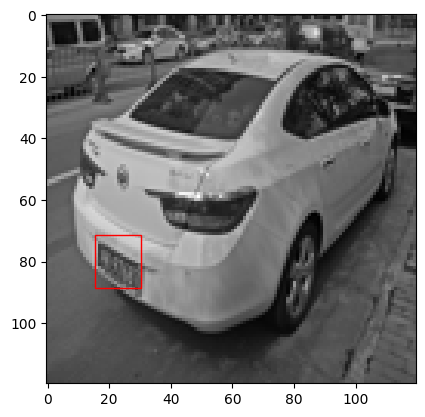

In [46]:
rand_index = randint(0,data_x.shape[0]-1)
#
#
#
#
#
#
x_matrix= data_x[randint(0,800)]
plt.figure()

fig, ax= plt.subplots()

ax.imshow(x_matrix, cmap= 'gray')
#
#
x= torch.from_numpy(x_matrix).type(torch.FloatTensor).view(1,*IMG_SIZE)#.to(device)# in case use GPU
#
y= modelBOX(x)

yp= y.cpu().detach().numpy()
rect=patches.Rectangle(
    (yp[0] * IMG_SIZE[0],yp[2] * IMG_SIZE[1]),
    (yp[1] - yp[0]) * IMG_SIZE[0],
    (yp[3] - yp[2]) * IMG_SIZE[1],
    linewidth= 1,
    edgecolor= "r",
    facecolor= "none",    
)
ax.add_patch(rect)
print(yp)